In [1]:
local_outgoing_path = '/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/TOC2ME'
shaheen2_path = '/scratch/birniece/TOC2ME'
shaheen3_path = '/home/birniece/TOC2ME'

# Notes:
- Split the sources into groups
- 200 sources per group
- 40 groups
- 20hr compute requested per group

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import scipy 
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline
import matplotlib.pyplot as plt

from pyfrac.utils.sofiutils import *

# FILE PATHS

In [3]:
expname = 'TOC2ME_Explosive'

In [4]:
# LOCAL PATHS
local_cp_dir = os.path.join(local_outgoing_path,expname)
shaheen2_proj_dir = os.path.join(shaheen2_path,expname)
shaheen3_proj_dir = os.path.join(shaheen3_path,expname)


In [5]:
# PANCAKE ONES 
shaheen_cp_loc = '/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/TOC2ME'
source_paths = os.path.join(shaheen_cp_loc,expname,'inputs/multishot_sources')
print(source_paths)

# 'FAKE' Shaheen Path
shaheen_proj_loc_scratch = '/scratch/birniece/TOC2ME/'
shaheen_proj_loc = os.path.join(shaheen_proj_loc_scratch,expname)

rec_file = os.path.join(shaheen_proj_loc,'inputs/TOC2ME_surfacenodes_xzy_5m.dat')
model_dir = os.path.join(shaheen_proj_loc,'inputs/model/ToC2ME_lateralhomo_XYZ_5m')

print(shaheen_proj_loc)

/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/TOC2ME/TOC2ME_Explosive/inputs/multishot_sources
/scratch/birniece/TOC2ME/TOC2ME_Explosive


In [6]:
sofi_shot_dir = os.path.join(shaheen_proj_loc,'inputs/multishot_sources')

sofimaster = '/scratch/birniece/sofi3d/bin/sofi3D'

# sofimaster = '/project/k1056/SOFI_FDmodelling/sofi3d/bin/sofi3D'

### SLURM FILE CREATION FUNC

In [7]:
def slurmfilecreation(slurmfile, gid, sofimaster, jsonloc, joutloc, write=True):
    slurmstr='''#!/bin/bash -l
#SBATCH --job-name=TOC2ME_multishot_%.2i
#SBATCH --nodes=32
#SBATCH --partition=workq
#SBATCH --time=23:00:00
#SBATCH --error=sofi.%%J.err 
#SBATCH --output=sofi.%%J.out

#OpenMP settings:
export OMP_NUM_THREADS=1

# RUN MODELLING JOB
srun --hint=nomultithread --ntasks=1000 %s %s.json > %s.jout
'''%(gid, sofimaster, jsonloc, joutloc)
    
    if write:
        text_file = open(slurmfile, "wt")
        text_file.writelines(slurmstr)
        text_file.close()

# MODELLING PARAMS (Indep. of src locs)

### MODEL PARAMETERS - Get these from the script that made the models

In [8]:
# TIME PARAMETERS
dt = 0.0001
tdur = 1.0

In [9]:
# SPATIAL PARAMETERS
dx = dy = dz = 5.
n_xzy = [1390, 1550, 1030]

# xmax = 1720
# ymax = 1920# y is y, I fix the SOFI ordering later
# zmax = 1680

# nx_homo = int(xmax//dx)
# ny_homo = int(ymax//dy)
# nz_homo = int(zmax//dz)
# n_xzy = [nx_homo, nz_homo, ny_homo]

d_xzy = [dx, dz, dy]

print(n_xzy[0]*dx,n_xzy[1]*dx,n_xzy[2]*dx)

6950.0 7750.0 5150.0


In [10]:
# BOUNDARIES & FREE SURFACE
nbounds = 30
free_surface = True

In [11]:
# SNAP PARAMETERS
snap_start = dt
snap_end = tdur/2
snap_step = 100*dt
tsnap_params = [snap_start, snap_end, snap_step]
snap_sbsmp_xyz = 1

# SEISMOGRAM PARAMETERS
smgrm_ndt = 10

In [12]:
# GET THE DIFFERENT STRINGS - this will be updated in the future
default_strs = get_default_strings(rec_file=rec_file)

# MODELLING
t_str = get_time_str(dt, tdur)
mod_strs = get_subsurfmod_str(n_xzy, 
                              d_xzy,
                              ' ',
                              moddir=model_dir,
                              np_xzy=[10,10,10]
                             )
bndry_str = get_boundary_str(fs=free_surface, 
                             npad=nbounds, 
                             cpml=True)


# SOURCES

sx (East)  3000 - 6000 most 3500 - 5500

sy (North) 4000 - 8000 most 5000 - 7000

sz (Depth) 2000 - 4000 most 2500 - 3500

In [13]:
datum = -980
mod_xmin = 930.0 
mod_ymin = 1770.0 

In [14]:
nsrc_large = 5000
nsrc_small = 5000

In [15]:
# LARGE SPACE 
sx_min = 3000 - mod_xmin
sx_max = 6000 - mod_xmin

sy_min = 4000 - mod_ymin
sy_max = 8000 - mod_ymin

sz_min = 2000 + datum
sz_max = 4000 + datum

grid_sx_locs = np.arange(sx_min,sx_max, d_xzy[0])
grid_sy_locs = np.arange(sx_min,sx_max, d_xzy[2])
grid_sz_locs = np.arange(sx_min,sx_max, d_xzy[1])

sx, sy, sz = np.meshgrid(grid_sx_locs,
                         grid_sy_locs,
                         grid_sz_locs) 
srclocs_large = np.vstack((sx.flatten(), sy.flatten(), sz.flatten()))# y is y, I fix the SOFI ordering later
print(srclocs_large.shape)

rng = np.random.default_rng()
rng.shuffle(srclocs_large,axis=1)
srclocs_large_selected = srclocs_large[:,:nsrc_large]


(3, 216000000)


In [16]:
# SMALLER SPACE 
sx_min = 3500 - mod_xmin
sx_max = 5500 - mod_xmin

sy_min = 5000 - mod_ymin
sy_max = 7000 - mod_ymin

sz_min = 2500 + datum
sz_max = 3500 + datum

grid_sx_locs = np.arange(sx_min,sx_max, d_xzy[0])
grid_sy_locs = np.arange(sx_min,sx_max, d_xzy[2])
grid_sz_locs = np.arange(sx_min,sx_max, d_xzy[1])

sx, sy, sz = np.meshgrid(grid_sx_locs,
                         grid_sy_locs,
                         grid_sz_locs) 
srclocs_small = np.vstack((sx.flatten(), sy.flatten(), sz.flatten()))# y is y, I fix the SOFI ordering later
print(srclocs_small.shape)

rng = np.random.default_rng()
rng.shuffle(srclocs_small,axis=1)
srclocs_small_selected = srclocs_small[:,:nsrc_small]

(3, 64000000)


In [17]:
# COMBINE SOURCE LOCS INTO ONE LIST 
srclocs = np.hstack((srclocs_large_selected, srclocs_small_selected))
srclocs.shape

(3, 10000)

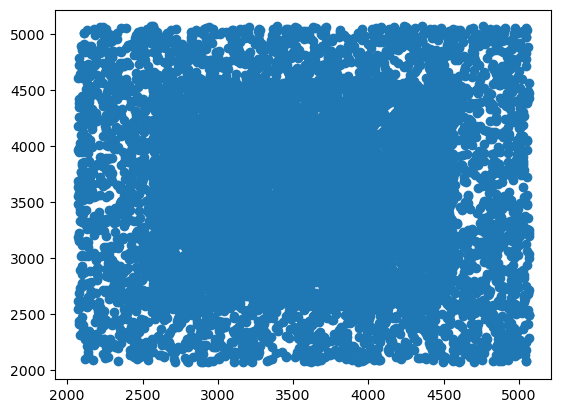

In [18]:
plt.scatter(srclocs[0],srclocs[1],)

In [19]:
src_xyz_list = []
for srcloc in srclocs.T:
    src_xyz_list.append(srcloc)
# src_xyz_list

In [20]:
# MAKE STRINGS PER SHOT LOC
td = dt  # ignition time
fc = 20  # central frequency
amp = 1.  # amplitude

string_list = []
for src in src_xyz_list:
    string_list.append([str(i) for i in [src[0], src[2], src[1], td, fc, amp]])

# WRITE FILES

In [21]:
# SELECT GROUPING OF SOURCES
src_per_group = 200

ns = srclocs.shape[1]
num_src_groups = int(ns/src_per_group)

print(num_src_groups)

50


In [22]:
src_cuts = np.arange(0,ns,src_per_group).astype('int')
for i,strt in enumerate(src_cuts):
    groupname = "multishot_group%.2i"%i
    print(groupname)
    
    # Write source file
    group_strings = string_list[strt:strt+src_per_group]
    src_filename = groupname+'.dat'
    # print(src_filename)
    src_file = os.path.join(source_paths,src_filename)  
    # print(src_file)  
    text_file = open(src_file, "wt")
    for string_line in group_strings:
        text_file.writelines('\t'.join(string_line)+'\n')
    text_file.close()

    # Make SOFI Source String
    sofi_src_file = os.path.join(sofi_shot_dir,src_filename)
    src_str = get_source_str(sfile=sofi_src_file, multisource=1)
    # print(src_str)
    
    # Make Monitor String
    monitor_strs = get_monitor_str(tsnap_params, 
                               smgrm_ndt, 
                               groupname, 
                               sbsmp_xyz=snap_sbsmp_xyz,
                               snap=False
                              )

    # Write SOFI FILE
    sofi_json_file = os.path.join(shaheen_cp_loc, expname, groupname+'.json')
    shaheen_sofi_json_file = os.path.join(shaheen_proj_loc, groupname+'.json')
    print(sofi_src_file)
    print(sofi_json_file)
    write_SOFIjsonParams(default_strs, 
                         monitor_strs,  
                         t_str, 
                         mod_strs, 
                         src_str, 
                         bndry_str,
                         sofi_json_file)

    # WRITE SLURM FILE
    slurmfile = os.path.join(shaheen_cp_loc, expname, 'submit_'+groupname+'.slurm')
    slurmfilecreation(slurmfile, 
                      gid=i, 
                      sofimaster=sofimaster, 
                      jsonloc=shaheen_sofi_json_file[:-5], 
                      joutloc=shaheen_sofi_json_file[:-5],)
    print(' ')

multishot_group00
/scratch/birniece/TOC2ME/TOC2ME_Explosive/inputs/multishot_sources/multishot_group00.dat
/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/TOC2ME/TOC2ME_Explosive/multishot_group00.json
 
multishot_group01
/scratch/birniece/TOC2ME/TOC2ME_Explosive/inputs/multishot_sources/multishot_group01.dat
/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/TOC2ME/TOC2ME_Explosive/multishot_group01.json
 
multishot_group02
/scratch/birniece/TOC2ME/TOC2ME_Explosive/inputs/multishot_sources/multishot_group02.dat
/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/TOC2ME/TOC2ME_Explosive/multishot_group02.json
 
multishot_group03
/scratch/birniece/TOC2ME/TOC2ME_Explosive/inputs/multishot_sources/multishot_group03.dat
/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/TOC2ME/TOC2ME_Explosive/multishot_group03.json
 
multishot_group04
/scratch/birniece/TOC2ME/TOC2M

# MAKE BASH SCRIPT TO SUBMIT ALL SLURM JOBS

In [23]:
slurmfiles = []
for file in glob.glob(os.path.join(shaheen_cp_loc,expname)+"/*.slurm"):
    slurmfiles.append(file.split('/')[-1])


In [24]:
slurmfiles[0]

'submit_multishot_group31.slurm'

In [25]:
bashsubmitfile = os.path.join(shaheen_cp_loc, expname,'submit_ALL.sh')

bashsubmitstring = '''#!/bin/bash 

mkdir -p outputs
mkdir -p outputs/log
mkdir -p outputs/snap
mkdir -p outputs/su

'''

for slurmf in slurmfiles:
    bashsubmitstring+='sbatch %s\n'%slurmf 
print(bashsubmitstring)

text_file = open(bashsubmitfile, "wt")
text_file.writelines(bashsubmitstring)
text_file.close()

#!/bin/bash 

mkdir -p outputs
mkdir -p outputs/log
mkdir -p outputs/snap
mkdir -p outputs/su

sbatch submit_multishot_group31.slurm
sbatch submit_multishot_group08.slurm
sbatch submit_multishot_group37.slurm
sbatch submit_multishot_group21.slurm
sbatch submit_multishot_group33.slurm
sbatch submit_multishot_group19.slurm
sbatch submit_multishot_group48.slurm
sbatch submit_multishot_group10.slurm
sbatch submit_multishot_group00.slurm
sbatch submit_multishot_group45.slurm
sbatch submit_multishot_group20.slurm
sbatch submit_multishot_group16.slurm
sbatch submit_multishot_group34.slurm
sbatch submit_multishot_group25.slurm
sbatch submit_multishot_group23.slurm
sbatch submit_multishot_group09.slurm
sbatch submit_multishot_group43.slurm
sbatch submit_multishot_group27.slurm
sbatch submit_multishot_group46.slurm
sbatch submit_multishot_group12.slurm
sbatch submit_multishot_group39.slurm
sbatch submit_multishot_group41.slurm
sbatch submit_multishot_group40.slurm
sbatch submit_multishot_group38